In [1]:
import os
import numpy as np
data_folder = os.path.join(os.path.expanduser("~"), "Data", "websites", "textonly")

documents = [open(os.path.join(data_folder, filename)).read() for filename in os.listdir(data_folder)]
len(documents)

490

In [2]:
pprint([document[:100] for document in documents[:5]])

Pretty printing has been turned OFF


In [3]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
from sklearn.pipeline import Pipeline

n_clusters = 10

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])

In [5]:
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, charset=None,
        charset_error=None, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(... n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0))])

In [6]:
labels = pipeline.predict(documents)

In [7]:
from collections import Counter
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 1 samples
Cluster 1 contains 2 samples
Cluster 2 contains 439 samples
Cluster 3 contains 1 samples
Cluster 4 contains 2 samples
Cluster 5 contains 3 samples
Cluster 6 contains 27 samples
Cluster 7 contains 2 samples
Cluster 8 contains 12 samples
Cluster 9 contains 1 samples


In [8]:
c[0]

1

In [9]:
pipeline.named_steps['clusterer'].inertia_

381.97317261989065

In [10]:
inertia_scores = []
n_cluster_values = list(range(2, 20))
for n_clusters in n_cluster_values:
    cur_inertia_scores = []
    X = TfidfVectorizer(max_df=0.4).fit_transform(documents)
    for i in range(30):
        km = KMeans(n_clusters=n_clusters).fit(X)
        cur_inertia_scores.append(km.inertia_)
    inertia_scores.append(cur_inertia_scores)
inertia_scores = np.array(inertia_scores)

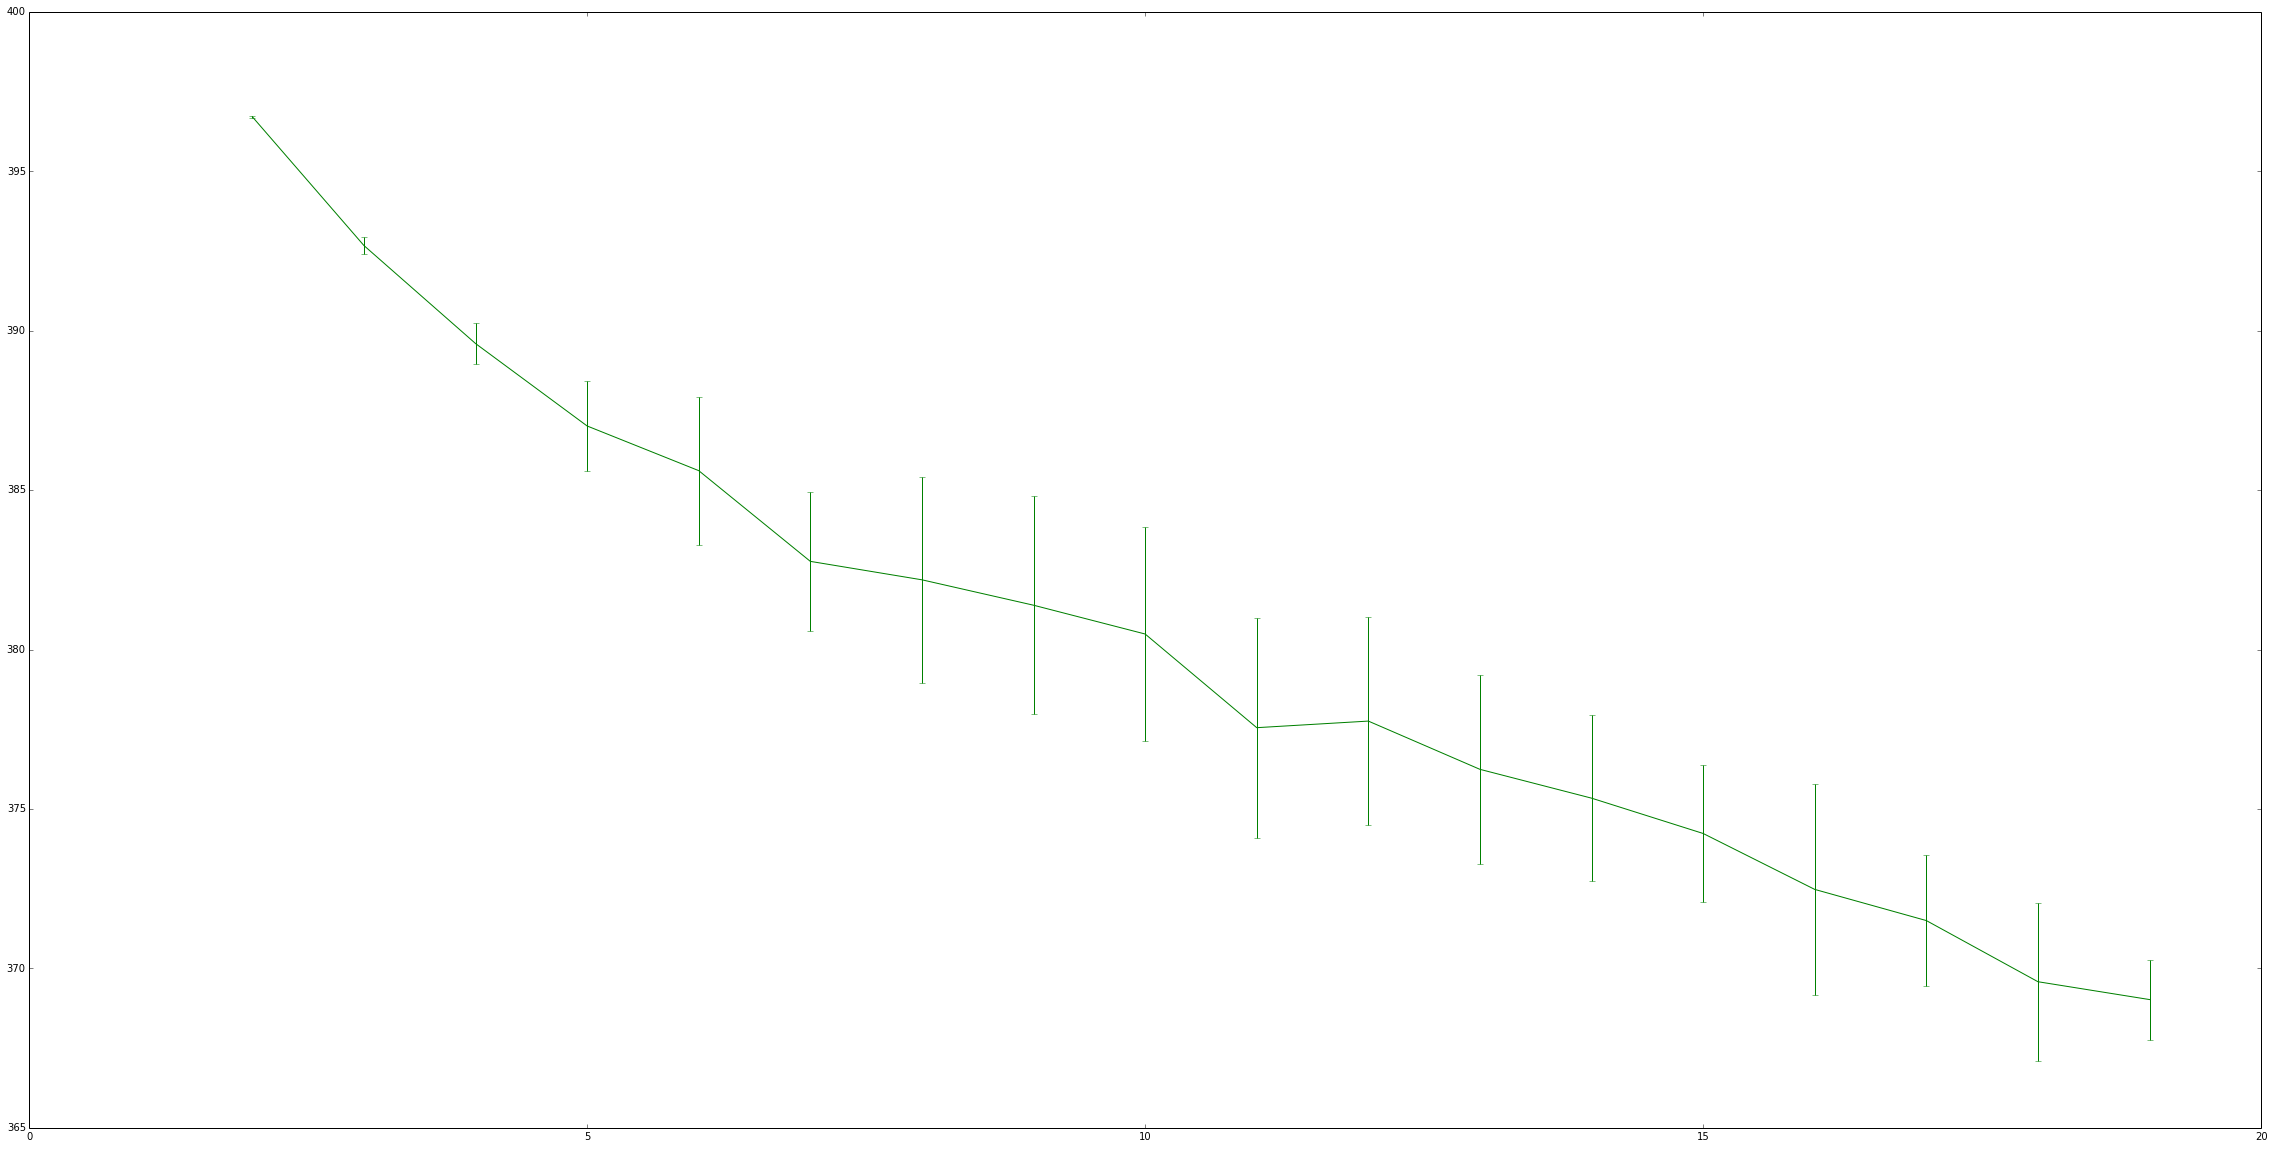

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

inertia_means = np.mean(inertia_scores, axis=1)
inertia_stderr = np.std(inertia_scores, axis=1)

fig = plt.figure(figsize=(40,20))
plt.errorbar(n_cluster_values, inertia_means, inertia_stderr, color='green')
plt.show()

In [12]:
n_clusters = 6

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, charset=None,
        charset_error=None, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(... n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0))])

In [13]:
labels = pipeline.predict(documents)

In [14]:
c = Counter(labels)

terms = pipeline.named_steps['feature_extraction'].get_feature_names()

for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
    print("  Most important terms")
    centroid = pipeline.named_steps['clusterer'].cluster_centers_[cluster_number]
    most_important = centroid.argsort()
    for i in range(5):
        term_index = most_important[-(i+1)]
        print("  {0}) {1} (score: {2:.4f})".format(i+1, terms[term_index], centroid[term_index]))
    print()

Cluster 0 contains 21 samples
  Most important terms
  1) korea (score: 0.1591)
  2) korean (score: 0.1573)
  3) south (score: 0.1336)
  4) kim (score: 0.1088)
  5) north (score: 0.1077)

Cluster 1 contains 33 samples
  Most important terms
  1) iran (score: 0.1047)
  2) netanyahu (score: 0.0869)
  3) nuclear (score: 0.0660)
  4) he (score: 0.0615)
  5) his (score: 0.0550)

Cluster 2 contains 156 samples
  Most important terms
  1) palestinian (score: 0.0196)
  2) israel (score: 0.0138)
  3) security (score: 0.0118)
  4) bank (score: 0.0115)
  5) its (score: 0.0103)

Cluster 3 contains 31 samples
  Most important terms
  1) browser (score: 0.2786)
  2) able (score: 0.2429)
  3) you (score: 0.2018)
  4) css (score: 0.1925)
  5) sheets (score: 0.1925)

Cluster 4 contains 48 samples
  Most important terms
  1) al (score: 0.0862)
  2) isis (score: 0.0723)
  3) islamic (score: 0.0664)
  4) iraq (score: 0.0657)
  5) state (score: 0.0580)

Cluster 5 contains 201 samples
  Most important terms

In [15]:
from sklearn.metrics import silhouette_score
X = pipeline.named_steps['feature_extraction'].transform(documents)
silhouette_score(X, labels)

0.031820420989154712

In [16]:
len(terms)

14327

In [17]:
Y = pipeline.transform(documents) 

In [18]:
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(Y)

In [19]:
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 89 samples
Cluster 1 contains 65 samples
Cluster 2 contains 7 samples
Cluster 3 contains 24 samples
Cluster 4 contains 290 samples
Cluster 5 contains 15 samples


In [20]:
silhouette_score(Y, labels)

0.56564461613141714

In [21]:
Y.shape

(490, 6)

# Evidence Accumulation Clustering

In [22]:
from scipy.sparse import csr_matrix


def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')


In [23]:
C = create_coassociation_matrix(labels)

In [24]:
C

<490x490 sparse matrix of type '<class 'numpy.float64'>'
	with 97096 stored elements in Compressed Sparse Row format>

In [25]:
C.shape, C.shape[0] * C.shape[1]

((490, 490), 240100)

In [26]:
len(C.nonzero()[0]) / (C.shape[0] * C.shape[1])

0.4043981674302374

In [27]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [28]:
mst = minimum_spanning_tree(C)

In [29]:
mst

<490x490 sparse matrix of type '<class 'numpy.float64'>'
	with 484 stored elements in Compressed Sparse Row format>

In [30]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=3))
                     ])
pipeline.fit(documents)
labels2 = pipeline.predict(documents)
C2 = create_coassociation_matrix(labels2)

In [31]:
C_sum = (C + C2) / 2
#C_sum.data = C_sum.data
C_sum.todense()

matrix([[ 1. ,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
        [ 0.5,  1. ,  1. , ...,  1. ,  1. ,  1. ],
        [ 0.5,  1. ,  1. , ...,  1. ,  1. ,  1. ],
        ..., 
        [ 0.5,  1. ,  1. , ...,  1. ,  1. ,  1. ],
        [ 0.5,  1. ,  1. , ...,  1. ,  1. ,  1. ],
        [ 0.5,  1. ,  1. , ...,  1. ,  1. ,  1. ]])

In [32]:
mst = minimum_spanning_tree(-C_sum)
mst

<490x490 sparse matrix of type '<class 'numpy.float64'>'
	with 489 stored elements in Compressed Sparse Row format>

In [33]:
#mst.data[mst.data < 1] = 0
mst.data[mst.data > -1] = 0
mst.eliminate_zeros()
mst

<490x490 sparse matrix of type '<class 'numpy.float64'>'
	with 481 stored elements in Compressed Sparse Row format>

In [34]:
from scipy.sparse.csgraph import connected_components
number_of_clusters, labels = connected_components(mst)

In [35]:

from sklearn.base import BaseEstimator, ClusterMixin

class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X))
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        mst.eliminate_zeros()
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [36]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', EAC())
                     ])

In [37]:
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, charset=None,
        charset_error=None, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(...ocabulary=None)), ('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))])

In [38]:
labels = pipeline.named_steps['clusterer'].labels_

In [39]:
c = Counter(labels)

In [40]:
c

Counter({0: 490})

# Online Learning

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
vec = TfidfVectorizer(max_df=0.4)

In [43]:
X = vec.fit_transform(documents)

In [44]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 500

indices = np.arange(0, X.shape[0])
for iteration in range(100):
    sample = np.random.choice(indices, size=batch_size, replace=True)
    mbkm.partial_fit(X[sample[:batch_size]])

In [74]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 10

for iteration in range(int(X.shape[0] / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    mbkm.partial_fit(X[start:end])

In [45]:
labels_mbkm = mbkm.predict(X)
mbkm.inertia_

401.6913550000382

In [46]:
km = KMeans(random_state=14, n_clusters=3)
labels_km = km.fit_predict(X)
km.inertia_

392.6561949236311

In [47]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score
from sklearn.metrics import mutual_info_score, v_measure_score

In [48]:
v_measure_score(labels_mbkm, labels_km)

0.39531764243316064

In [49]:
X.shape

(490, 14327)

In [50]:
labels_mbkm

array([2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2,
       2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2,

In [52]:
from sklearn.feature_extraction.text import HashingVectorizer

In [66]:
class PartialFitPipeline(Pipeline):
    def partial_fit(self, X, y=None):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][1].partial_fit(Xt, y=y)

In [67]:
pipeline = PartialFitPipeline([('feature_extraction', HashingVectorizer()),
                             ('clusterer', MiniBatchKMeans(random_state=14, n_clusters=3))
                             ])

In [75]:
batch_size = 10

for iteration in range(int(len(documents) / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    pipeline.partial_fit(documents[start:end])

In [76]:
labels = pipeline.predict(documents)
labels

array([0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2,
       1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0,
       0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2,
       1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 2,